In [12]:
import cupy as cp
import pickle
import os
os.chdir('/home/ubuntu/nk-paper-2024/nk-ml-2024/notebooks/')
import optuna as opt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
#from twilio.rest import Client
import pickle

import time

import sys
import os 






import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
sys.path.append('../../pscapes')
sys.path.append('../../nk-ml-2024/')


from torch.utils.data import DataLoader
from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array, np_array_to_dict

from src.architectures import SequenceRegressionCNN, SequenceRegressionLinear, SequenceRegressionMLP, SequenceRegressionLSTM, SequenceRegressionTransformer

from src.ml_utils import train_val_test_split_ohe, landscapes_ohe_to_numpy
from src.hyperopt import objective_NK, sklearn_objective_NK

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 

from src.train_utils import train_models_from_hparams_NK, read_MLP_hparams, read_CNN_hparams, read_LSTM_hparams, read_transformer_hparams, instantiate_model_from_study

from src.analysis import get_latent_representation
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import math
import networkx as nx
from scipy.sparse import diags

import torchmetrics
from torchmetrics.regression import SpearmanCorrCoef, PearsonCorrCoef
from src.analysis import adjacency_to_diag_laplacian, sparse_dirichlet


In [13]:
#set global parameters
HPARAM_PATH = '../hyperopt/results/NK_hyperopt_results.pkl'
DATA_PATH = '../data/nk_landscapes/'
MODEL_SAVEPATH = '../models/models_K3/'
RESULT_PATH = '../results/results_K3/NK_train_test_results.pkl'
SEQ_LEN = 6
AA_ALPHABET  = 'ACDEFG'
N_REPLICATES = 4

In [14]:
#load landscapes
#load landscape data 
landscapes = []
print('Loading landscapes.')
for k in range(SEQ_LEN):
    replicate_list = []
    for r in range(N_REPLICATES):
        landscape = ProteinLandscape(csv_path=DATA_PATH+'/k{0}_r{1}.csv'.format(k,r), amino_acids=AA_ALPHABET)
        replicate_list.append(landscape)
    landscapes.append(replicate_list)
landscapes = [[i.fit_OHE() for i in j] for j in landscapes]

print('Calculating train-test-val splits')
splits = [train_val_test_split_ohe(i, random_state=1) for i in landscapes]
#landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_index] 

Loading landscapes.
Calculating train-test-val splits


In [4]:
with open('knn_nk_k1_r1_array.pkl', 'rb') as handle: 
    knn_nk_k1_r1 = pickle.load( handle)

In [5]:
with open('knn_mlp_k1_r1_array.pkl', 'rb') as handle: 
    knn_mlp_k1_r1 = pickle.load( handle)

In [3]:
from scipy.sparse.linalg import eigsh

In [8]:
nk_k1_r1_eigvals,nk_k1_r1_eigvecs = eigsh(knn_nk_k1_r1, k=1000)

In [10]:
mlp_k1_r1_eigvals,mlp_k1_r1_eigvecs = eigsh(knn_mlp_k1_r1, k=1000)

In [15]:
landscapes_y       = [[i.fitnesses.reshape(-1,1) for i in j] for j in landscapes]

In [16]:
landscapes_y_k1_r1 = landscapes_y[1][1]

In [19]:
spect_nk_k1_r1 = nk_k1_r1_eigvecs.T@landscapes_y_k1_r1

In [42]:
spect_nk_k1_r1_cum_sum = np.cumsum(np.absolute(spect_nk_k1_r1[::-1]))

In [43]:
spect_mlp_k1_r1 = mlp_k1_r1_eigvecs.T@landscapes_y_k1_r1

In [47]:
spect_mlp_k1_r1_cum_sum = np.cumsum(np.absolute(spect_mlp_k1_r1[::-1]))

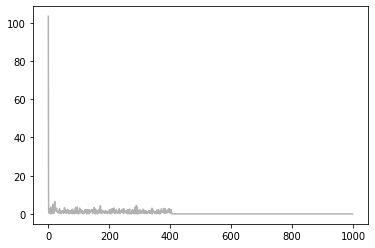

In [50]:
plt.plot(np.absolute(spect_nk_k1_r1[::-1]), c='k', alpha=0.3)
#plt.plot(spect_nk_k1_r1_cum_sum)


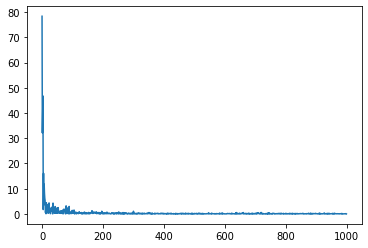

In [49]:
plt.plot(np.absolute(spect_mlp_k1_r1[::-1]))
#plt.plot(spect_mlp_k1_r1_cum_sum)